Cleaned dataset shape: (21396, 19)
R2 Score: 0.8721
RMSE: $100,868.32


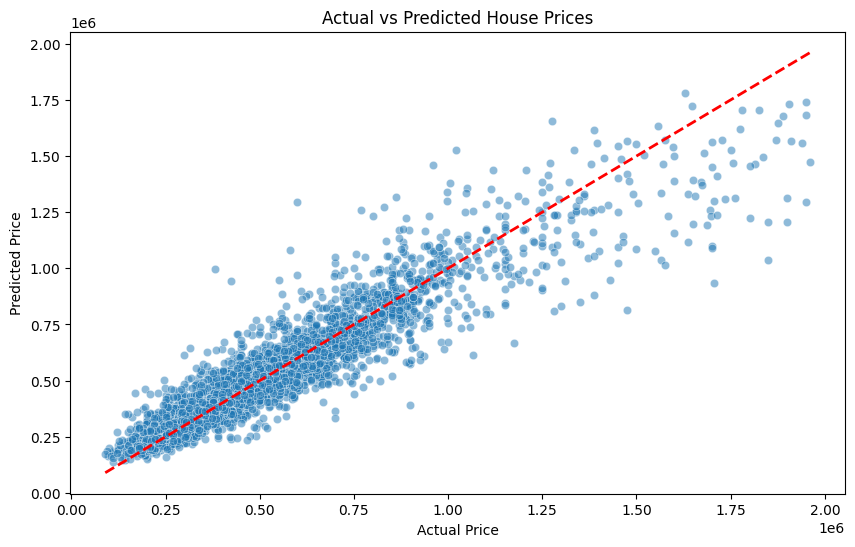

Model saved using joblib!


In [19]:
# 01_Environment Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# Load the data
df = pd.read_csv('housing_data.csv')

# Quick look
df.head()


# 02_Data Cleaning & Preprocessing

# 1. Drop unnecessary columns
df = df.drop(['id', 'date'], axis=1)

# 2. Handle missing values (though this dataset is usually clean)
df = df.fillna(df.median())

# 3. Simple Outlier Removal (Removing top 1% of prices to normalize data)
q_limit = df['price'].quantile(0.99)
df = df[df['price'] < q_limit]

print(f"Cleaned dataset shape: {df.shape}")


# 03_Feature Engineering

# Create Age of the house at time of sale (assuming 2015 as base year)
df['house_age'] = 2015 - df['yr_built']

# If renovated, we can use that year instead
df['years_since_renovation'] = df.apply(lambda x: 2015 - x['yr_renovated'] if x['yr_renovated'] > 0 else x['house_age'], axis=1)

# Drop original year columns
df = df.drop(['yr_built', 'yr_renovated'], axis=1)


# 04_Model Training & Hyperparameter Tuning
# Split Data
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Important for some models, good practice for all)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Selection: Random Forest
# Tuning: You can manually adjust n_estimators and max_depth
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
model.fit(X_train_scaled, y_train)


# 05_Evaluation & Visualization
predictions = model.predict(X_test_scaled)

# Metrics
print(f"R2 Score: {r2_score(y_test, predictions):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, predictions)):,.2f}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.show()


# 06_Saving the Model for Deployment

# Save the model and scaler to files
import joblib

# Save the model with compression (level 3 is usually plenty)
joblib.dump(model, 'house_model.joblib', compress=3)

# Save the scaler as well (scalers are small, but let's be consistent)
joblib.dump(scaler, 'scaler.joblib')

print("Model saved using joblib!")

In [20]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib # Using joblib as we discussed for GitHub

# Load the saved model and scaler
# Note: Use joblib.load if you saved with joblib, or pickle.load if you used pickle
model = joblib.load('house_model.joblib')
scaler = joblib.load('scaler.joblib')

st.title("🏡 King County House Price Predictor")

# 1. Inputs
sqft_living = st.slider("Square Feet Living Area", 500, 10000, 2000)
bedrooms = st.number_input("Number of Bedrooms", 1, 10, 3)
bathrooms = st.number_input("Number of Bathrooms", 1, 8, 2)
grade = st.slider("House Grade (Construction Quality)", 1, 13, 7)
yr_built = st.number_input("Year Built", 1900, 2015, 1990)

# 2. Feature Engineering
house_age = 2015 - yr_built

# 3. Prepare Input (Fixing the Feature Name Warning)
feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
                'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'years_since_renovation']

# Create a DataFrame so the scaler doesn't warn you about "missing names"
input_df = pd.DataFrame(np.zeros((1, 18)), columns=feature_cols)
input_df['bedrooms'] = bedrooms
input_df['bathrooms'] = bathrooms
input_df['sqft_living'] = sqft_living
input_df['grade'] = grade
input_df['house_age'] = house_age

# 4. Predict
if st.button("Predict Price"):
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)
    st.success(f"The estimated value of this house is: ${prediction[0]:,.2f}")

Overwriting app.py


In [21]:
# Save this block as app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load the saved model and scaler
model = pickle.load(open('house_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))

st.title("🏡 King County House Price Predictor")
st.write("Enter the details of the house to get an estimated market price.")

# User Inputs (simplified for the demo)
sqft_living = st.slider("Square Feet Living Area", 500, 10000, 2000)
bedrooms = st.number_input("Number of Bedrooms", 1, 10, 3)
bathrooms = st.number_input("Number of Bathrooms", 1, 8, 2)
grade = st.slider("House Grade (Construction Quality)", 1, 13, 7)
yr_built = st.number_input("Year Built", 1900, 2015, 1990)

# Feature Engineering (Must match the training logic)
house_age = 2015 - yr_built

# Create a placeholder for all features (initialized to averages or zeros)
# In a real app, you'd provide inputs for all features used in training
input_data = np.zeros((1, 18))
# Mapping the indices (This matches the feature order in your training)
input_data[0, 0] = bedrooms
input_data[0, 1] = bathrooms
input_data[0, 2] = sqft_living
input_data[0, 8] = grade
input_data[0, 16] = house_age

# Scale and Predict
input_scaled = scaler.transform(input_data)
prediction = model.predict(input_scaled)

if st.button("Predict Price"):
    st.success(f"The estimated value of this house is: ${prediction[0]:,.2f}")

2026-02-06 09:27:31.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.498 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 09:27:31.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [13]:
!pip install -q streamlit
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.63.123.215:8501

  Stopping...


In [22]:
# Use the direct link to  GitHub raw file
test_df = pd.read_csv('https://raw.githubusercontent.com/kelly7y176/house-price-prediction/main/housing_data.csv')
print(test_df.head())

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     lo